<img src="https://www.rp.edu.sg/images/default-source/default-album/rp-logo.png" width="200" alt="Republic Polytechnic"/>

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/koayst-rplesson/SST_DP2025/blob/main/Day_02/L13/L13_Challenge_Answer.ipynb)

# Setup and Installation

You can run this Jupyter notebook either on your local machine or run it at Google Colab (preferred).

* For local machine, it is recommended to install Anaconda and create a new development environment called `SST_DP2025`.
* Pip/Conda install the libraries stated below when necessary.
---

# <font color='red'>ATTENTION</font>

## Google Colab
- If you are running this code in Google Colab, **DO NOT** store the API Key in a text file and load the key later from Google Drive. This is insecure and will expose the key.
- **DO NOT** hard code the API Key directly in the Python code, even though it might seem convenient for quick development.
- You need to enter the API key at Python code `getpass.getpass()` when ask.

## Local Environment/Laptop
- If you are running this code locally in your laptop, you can create a env.txt and store the API key there.
- Make sure env.txt is in the same directory of this Jupyter notebook.
- You need to install `python-dotenv` and run the Python code to load in the API key.

---
```
%pip install python-dotenv

from dotenv import load_dotenv

load_dotenv('env.tx')
openai_api_key = os.getenv('OPENAI_API_KEY')
```
---

## GitHub/GitLab
- **DO NOT** `commit` or `push` API Key to services like GitHub or GitLab.

# Lesson 13 Challenge

In [ ]:
%%capture --no-stderr
%pip install --quiet -U langchain
%pip install --quiet -U langgraph
%pip install --quiet -U langchain-openai
%pip install --quiet -U langchain-community
%pip isntall --quiet -U tavily-python
%pip install --quiet -U wikipedia
%pip install --quiet -U "langchain-chroma>=0.1.2"
%pip install --quiet -U pymupdf

In [ ]:
# langchain              0.3.11
# langgraph              0.2.59
# langchain-core         0.3.24
# langchain-openai       0.2.12
# langchain-community    0.3.12
# openai                 1.57.2
# pydantic               2.10.3
# tavily-python          0.5.0
# wikipedia              1.4.0
# chroma                 0.5.23
# PyMuPDF                1.25.1

In [1]:
import getpass
import os

In [2]:
# setup the OpenAI API Key

# get OpenAI API key ready and enter it when ask
os.environ["OPENAI_API_KEY"] = getpass.getpass()

 ········


In [3]:
# Goto https://tavily.com/ and sign up to get an API key

# get Tavily Search API key ready and enter it when ask
os.environ["TAVILY_API_KEY"] = getpass.getpass()

 ········


---

## Activity 1

<img src="harrypotter.png" width="70%" height="auto">

We are building a Retrieval-Augmented Generation (RAG) application using an LLM to answer questions about Harry Potter the book "The Sorcerer’s Stone". Complete the code, construct the graph, and run tests to ensure functionality. Feel free to enhance the implementation.

## <font color="#FF0000">IMPORTANT</font>
If you are running this code in Google Colab, you need to run the below commands to download `Harry Potter_The Sorcerers Stone.pdf` to Google Colab.

Comment out the below code with '#' if you are not running it in your local machine.

In [ ]:
!wget "https://raw.githubusercontent.com/koayst-rplesson/SST_DP2025/refs/heads/main/Day_02/L13/Harry Potter_The Sorcerers Stone.pdf"
!dir

In [4]:
from langchain_chroma import Chroma
from langchain_community.document_loaders import PyMuPDFLoader

from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_text_splitters.character import RecursiveCharacterTextSplitter

from langchain_core.prompts.chat import ChatPromptTemplate
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.output_parsers import StrOutputParser

from pydantic import BaseModel, Field
from typing import List, Optional

from langgraph.graph import StateGraph, START, END

In [5]:
# set up the model

llm_model = ChatOpenAI(
    model = 'gpt-4o-mini',
)

In [6]:
# set up the PDF loader

loader = PyMuPDFLoader("Harry Potter_The Sorcerers Stone.pdf")

In [7]:
# load the PDF using the PDF loader

hp_pages = []
for page in loader.load():
    hp_pages.append(page)

# ignore the user warnings since pages 0 and 1 are blank pages

C:\Users\koay_seng_tian\AppData\Local\anaconda3\envs\c3669c\lib\site-packages\langchain_community\document_loaders\parsers\pdf.py:322: UserWarning: Warning: Empty content on page 0 of document Harry Potter_The Sorcerers Stone.pdf
  warnings.warn(
C:\Users\koay_seng_tian\AppData\Local\anaconda3\envs\c3669c\lib\site-packages\langchain_community\document_loaders\parsers\pdf.py:322: UserWarning: Warning: Empty content on page 1 of document Harry Potter_The Sorcerers Stone.pdf
  warnings.warn(


In [8]:
# print some information about the PDF

print(f'We have {len(hp_pages)} pages in total\n')
print('-'*13)

# print page 100th
print(f'Page Content:\n{"-"*13}\n{hp_pages[100].page_content}')

We have 221 pages in total

-------------
Page Content:
-------------
was standing on their stools while Neville, who had been drenched in the potion
when the cauldron collapsed, moaned in pain as angry red boils sprang up all
over his arms and legs.
      “Idiot boy!” snarled Snape, clearing the spilled potion away with one
wave of his wand. “I suppose you added the porcupine quills before taking the
cauldron off the fire?”
      Neville whimpered as boils started to pop up all over his nose.
      “Take him up to the hospital wing,” Snape spat at Seamus. Then he
rounded on Harry and Ron, who had been working next to Neville.
      “You — Potter — why didn’t you tell him not to add the quills? Thought
he’d make you look good if he got it wrong, did you? That’s another point
you’ve lost for Gryffindor.”
      This was so unfair that Harry opened his mouth to argue, but Ron kicked
him behind their cauldron.
      “Don’t push it,” he muttered, “I’ve heard Snape can turn very nasty.”
    

In [9]:
# set up the text splitter (chunking)

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 800,
    chunk_overlap = 100
)

# split the text
texts = text_splitter.split_documents(hp_pages)
print(f'We have created {len(texts)} chunks from {len(hp_pages)} pages')

We have created 757 chunks from 221 pages


In [10]:
# set up vector store as a retriever

vectorstore = Chroma.from_documents(
    collection_name = "rag-chroma",
    documents = texts,

    # Note: 
    # if you use Chroma.from_documents, you should use 'embedding'
    # if you use Chroma, you should use "embedding_function'    
    embedding = OpenAIEmbeddings(),
    persist_directory = "./chroma_langchain_db",
)

retriever = vectorstore.as_retriever()

In [11]:
# define the state of the graph 

class GraphState(BaseModel):
    question: Optional[str] = None     # Optional string, default is None
    generation: Optional[str] = None   # Optional string, default is None
    documents: List[str] = []          # Defaults to an empty list

In [12]:
# set up the system and human prompts

system_prompt = """
You are an assistant for question-answering tasks.
Use the following pieces of retrieved context to answer the question.
If you don't know the answer, just say you don't know.
Use maximum of three sentences and keep the answer concise.
Only provide the answer and nothing else!
"""

human_prompt="""
Question: {question}

Context: {context}

Answer:
"""

sys_msg = SystemMessage(
    content="You are a helful assistant tasked with performing arithmetic operations."
)

In [13]:
rag_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", human_prompt)
    ]
)

In [14]:
# set up the rag pipeline

rag_chain = rag_prompt | llm_model | StrOutputParser()

In [15]:
# define the retrieval node for the graph

def retrieval_node(state: GraphState):
    new_documents = retriever.invoke(state.question)
    new_documents = [d.page_content for d in new_documents]
    state.documents.extend(new_documents)
    return {"documents" : state.documents}

In [16]:
# define the generation node for the graph

def generation_node(state: GraphState): 
    generation = rag_chain.invoke({
        "context" : "\n\n".join(state.documents),
        "question" : state.question,
    })

    return {"generation" : generation}

In [17]:
# build the graph

graph_builder = StateGraph(GraphState)

graph_builder.add_node('retrieval_node', retrieval_node)
graph_builder.add_node('generation_node', generation_node)

graph_builder.add_edge(START, 'retrieval_node')
graph_builder.add_edge('retrieval_node', 'generation_node')
graph_builder.add_edge('generation_node', END)

graph = graph_builder.compile()

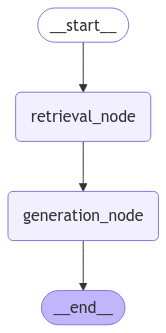

In [18]:
# View Graph
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

### Q&A Samples for Your Observation Comparison
They were generated using online ChatGPT.

---

**Q: How does Harry discover he is a wizard?**
A: Harry discovers he is a wizard on his eleventh birthday when Hagrid visits him at the Dursleys' home. Hagrid delivers a letter from Hogwarts School of Witchcraft and Wizardry, explains Harry’s true heritage, and reveals that he is famous in the wizarding world for surviving Voldemort’s attack as a baby.

**Q: What is the significance of the Sorcerer’s Stone, and why is it hidden at Hogwarts?**
A: The Sorcerer’s Stone, created by Nicolas Flamel, has the power to grant immortality and produce unlimited gold. It is hidden at Hogwarts to keep it safe from Voldemort, who seeks it to regain his physical form and power. The stone is guarded by a series of magical challenges created by Hogwarts professors, including a giant three-headed dog named Fluffy and various enchanted obstacles.

**Q: How does Harry ultimately defeat Professor Quirrell and prevent Voldemort from getting the Stone?**
A: Harry confronts Professor Quirrell, who is possessed by Voldemort, in the final chamber. When Quirrell tries to seize the Sorcerer’s Stone, he cannot touch Harry due to the protective magic left by Harry’s mother’s sacrifice. This love-based protection causes Quirrell immense pain and ultimately leads to Voldemort fleeing, leaving Harry victorious.

**Q: What role does the Mirror of Erised play in the story?**
A: The Mirror of Erised shows the viewer their deepest desires. For Harry, it displays his parents, highlighting his longing for family. The mirror serves as a tool for self-reflection and an important plot device when Dumbledore uses it to hide the Sorcerer’s Stone. Only someone who seeks the Stone without selfish intent can retrieve it, a test Voldemort fails.

**Q: How does Harry ultimately defeat Professor Quirrell and prevent Voldemort from getting the Stone?**
A: Harry confronts Professor Quirrell, who is possessed by Voldemort, in the final chamber. When Quirrell tries to seize the Sorcerer’s Stone, he cannot touch Harry due to the protective magic left by Harry’s mother’s sacrifice. This love-based protection causes Quirrell immense pain and ultimately leads to Voldemort fleeing, leaving Harry victorious.

---

In [19]:
# question to be asked by user

user_input = {'question' : 'How does Harry ultimately defeat Professor Quirrell and prevent Voldemort from getting the Stone?'}

In [20]:
# run the graph to generate the output

for chunk in graph.stream(user_input, stream_mode='updates'):
    for node, values in chunk.items():
        print(f"Receiving update from node: '{node}'")
        print(values)
        print("-"*10)

Receiving update from node: 'retrieval_node'
{'documents': ['Quirrell cursed again.\n      “Get out of the way,” he said. As Harry moved aside, he felt the\nSorcerer’s Stone against his leg. Dare he make a break for it?\n      But he hadn’t walked five paces before a high voice spoke, though\nQuirrell wasn’t moving his lips.\n      “He lies…He lies.…”\n      “Potter, come back here!” Quirrell shouted. “Tell me the truth! What did\nyou just see?”\n      The high voice spoke again.\n      “Let me speak to him…face-to-face…”\n      “Master, you are not strong enough!”\n      “I have strength enough…for this…”\n      Harry felt as if Devil’s Snare was rooting him to the spot. He couldn’t\nmove a muscle. Petrified, he watched as Quirrell reached up and began to\nunwrap his turban. What was going on? The turban fell away. Quirrell’s head', 'Quirrell cursed again.\n      “Get out of the way,” he said. As Harry moved aside, he felt the\nSorcerer’s Stone against his leg. Dare he make a break fo

---

## Activity 2

<img src="Wikipedia_Logo_1.0.png" width="20%" height="auto">

We will be using Wikipedia and a Google search services to gather contexts to answer a question directed to the LLM. You are to complete the code and build the graph. Run test on it to ensure that it is working. Feel free to improve it.

**NOTE**</br>
Make sure you have signed up at [Tavily](https://tavily.com/) and get an API key before continuing.

In [21]:
from langchain_openai import ChatOpenAI

from langchain_core.messages import HumanMessage, SystemMessage

from langchain_community.document_loaders import WikipediaLoader
from langchain_community.tools.tavily_search import TavilySearchResults

from langgraph.graph import StateGraph, START, END

from typing import Annotated
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages
from typing_extensions import TypedDict

from IPython.display import Image, display

In [22]:
# use 'gpt-4o-mini`

model = ChatOpenAI(
    model = 'gpt-4o-mini'
)

In [23]:
# complete the code
class State(TypedDict):
    # the question to be send to the LLM
    question: str

    # the answer returned by the LLM
    answer: str

    # a list of context is created
    # from the searches 
    context: Annotated[list[AnyMessage], add_messages]

In [24]:
# search_web node is defined as below

def search_web(state):
    """ Retrieve docs from web search """
    tavily_search = TavilySearchResults(max_results=3)    # return three search result
    search_docs = tavily_search.invoke(state['question'])

    # format the search result
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>' for doc in search_docs            
        ]
    )

    return {"context" : [formatted_search_docs]}

In [25]:
# search_wikipedia node is defined as below

def search_wikipedia(state):
    
    """ Retrieve docs from wikipedia """
    # Search
    search_docs = WikipediaLoader(
        query=state['question'], 
        load_max_docs=2).load()

    # format the search result
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]} 

In [26]:
# generate_answer node is defined as below

def generate_answer(state):
    """ Node to generate answer """

    # get context and question from state
    context = state['context']
    question = state['question']

    answer_template = """Answer the question: {question} using this context: {context}"""
    answer_instructions = answer_template.format(question = question, context = context)

    # Now get the model (LLM) to answer
    answer = model.invoke(
        [SystemMessage(content = answer_instructions)] +
        [HumanMessage(content = "Please answer the question and indicate the source of truth.")]
    )

    return {"answer" : answer}  

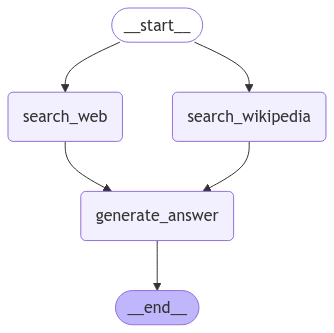

In [27]:
# Build the graph

# initialise the state graph
builder = StateGraph(State)

# setup the nodes
builder.add_node("search_web", search_web)
builder.add_node("search_wikipedia", search_wikipedia)
builder.add_node("generate_answer", generate_answer)

# connect the nodes
builder.add_edge(START, "search_web")
builder.add_edge(START, "search_wikipedia")
builder.add_edge("search_wikipedia", "generate_answer")
builder.add_edge("search_web", "generate_answer")
builder.add_edge("generate_answer", END)

#compile the graph as assistant
assistant = builder.compile()

# display the graph
display(Image(assistant.get_graph().draw_mermaid_png()))

In [28]:
# invoke the graph to send the question to the LLM
# question is "How were Nvidia's Q2 2024 earnings?"
# once you got it running feel free to invoke the 
# graph with your own question
result = assistant.invoke({"question": "How were Nvidia's Q2 2024 earnings?"})

# print the answer to the question
print(result['answer'].content)

Nvidia's Q2 2024 earnings were exceptionally strong, with GAAP earnings per diluted share reaching $2.48, which represents an impressive increase of 854% year-over-year and 202% over the previous quarter. The company significantly exceeded both revenue and earnings-per-share estimates for the quarter, driven largely by a surge in demand for its Data Center segment, particularly related to accelerated computing and generative AI solutions.

(Source: Shacknews and AnandTech articles on Nvidia's Q2 2024 earnings)


---